## Johnson & Johnson quarterly earnings per share

In [1]:
library(astsa)

### 1. Time Plot  
1. Outlier 
2. Change of mean  在变大  
3. Change of variance 在变大  

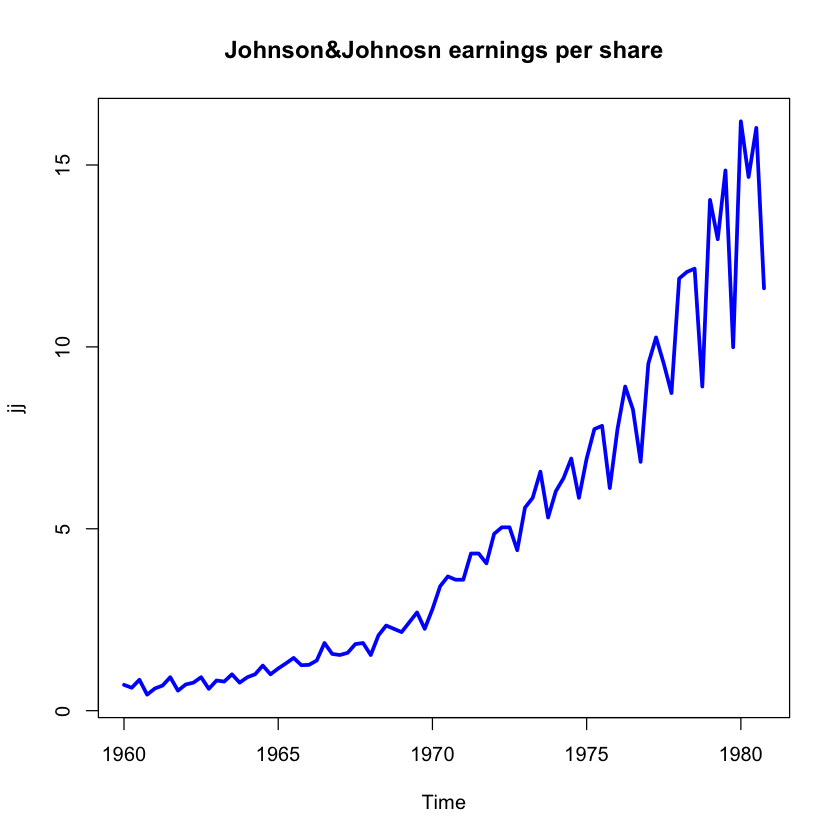

In [2]:
plot(jj, main='Johnson&Johnosn earnings per share', col='blue', lwd=3)

### 2. Transformation  

1. Stablize the variance by log()
2. Check 'd'
3. Check 'D'

Log-return a time series ${X_t}$ is defined as  


$$ r_t = \log\frac{X_t}{X_{t-1}} = \log(X_t) - \log(X_{t-1}) $$  

In R, $diff(log(...))$

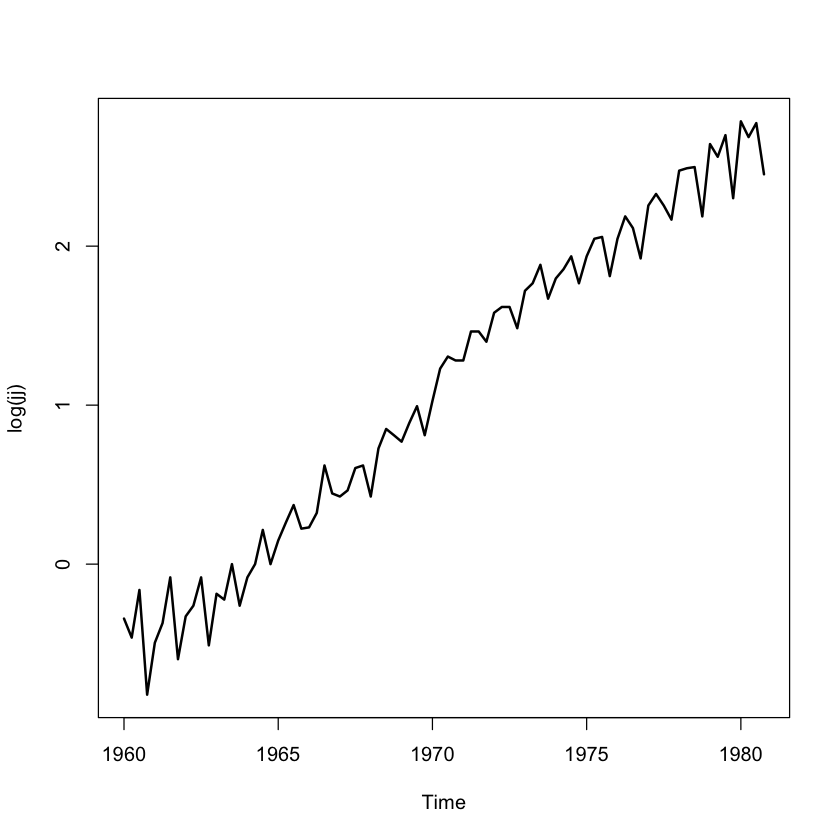

In [3]:
plot(log(jj), lwd=2)

Variance is handled!

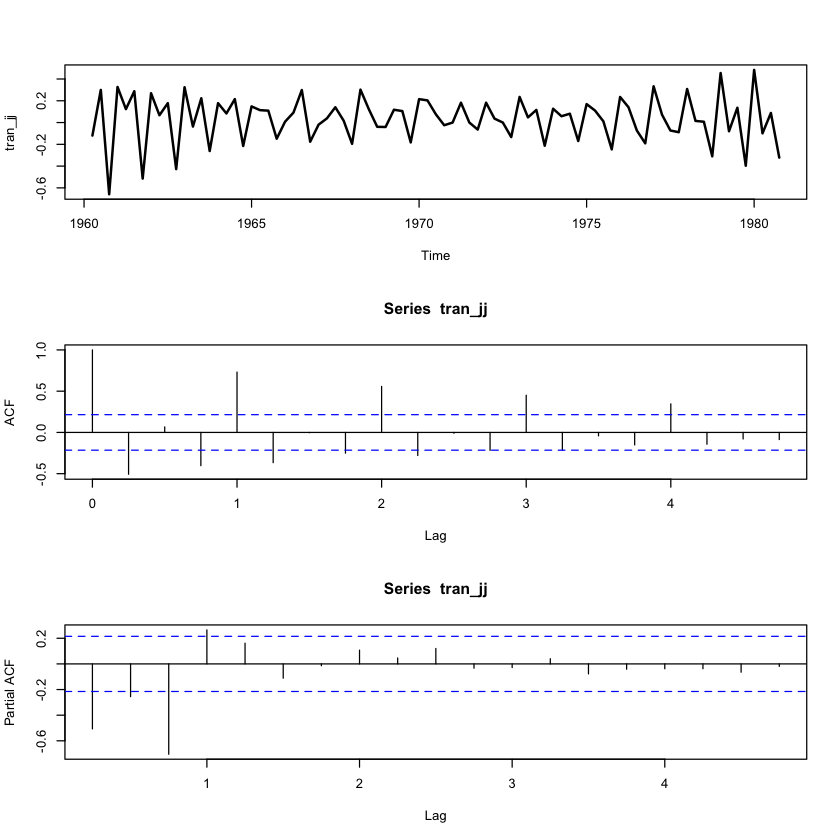

In [4]:
# check small 'd'
tran_jj = diff(log(jj))
par(mfrow=c(3, 1))
plot(tran_jj, lwd=2)
acf(tran_jj)
pacf(tran_jj)

我们可以看到经过整理的JJ，均值和方差有所改善，但是中间区域似乎方差有变小。__d的可能取值为1__  
ACF 我们可以看到lag4,lag8,lag12...显示有强相关性, 预示在seasonal上 __'D'可能的取值为1, m=4__  
ACF 可以看到 __q = 0, 1__  
PACF 我们可以看到 __p = 0, 1__ (lag3 以及前后的lag2/lag4 可能是因为周期性引入）  

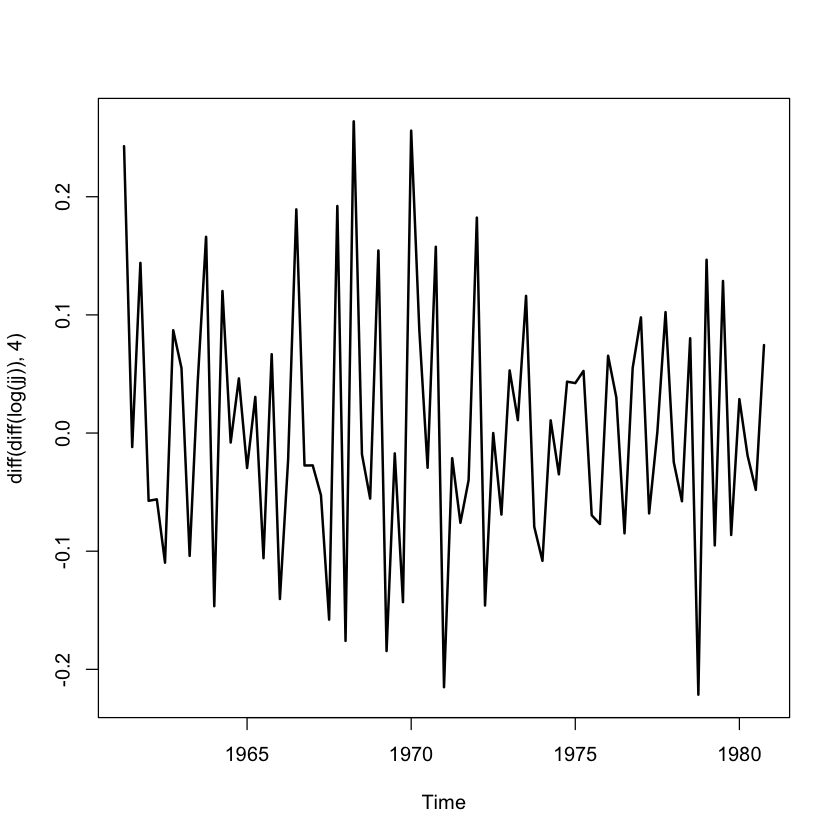

In [5]:
# 检查seasonal difference with 4
plot(diff(diff(log(jj)), 4), lwd=2)

### Ljung-Box Test  
H0：判定在指定的m个lag内，不存在自相关性  
如果p-value 极小，则可以推翻H0  
m的取值为 $log(len(ts))$

In [11]:
Box.test(diff(diff(log(jj)),4), lag=log(length(jj)))


	Box-Pierce test

data:  diff(diff(log(jj)), 4)
X-squared = 20.95, df = 4.4308, p-value = 0.0004938


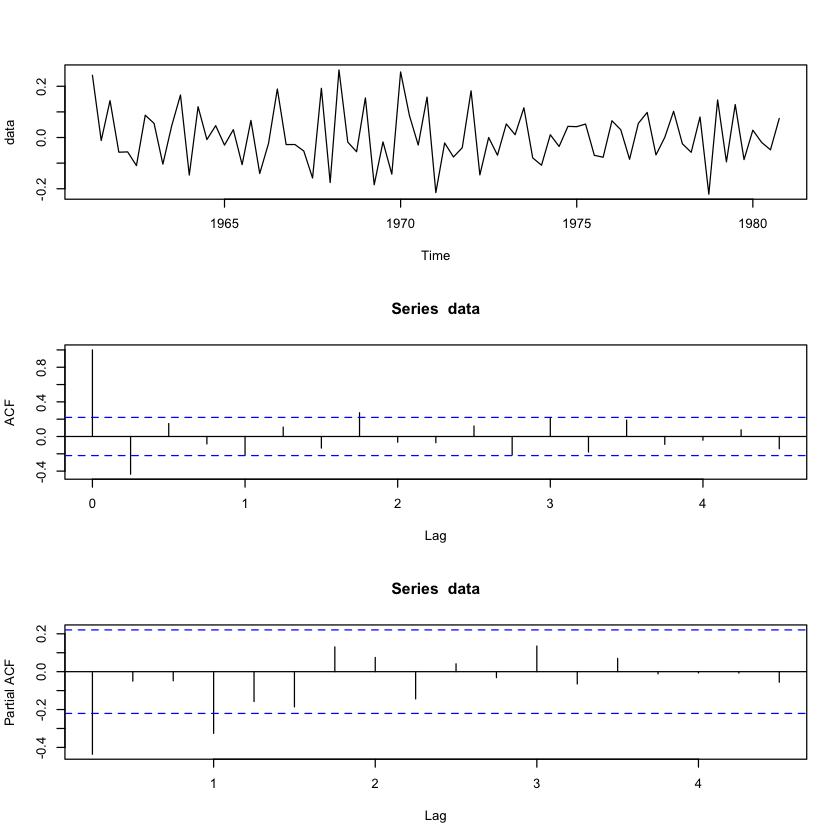

In [14]:
data = diff(diff(log(jj)),4)
par(mfrow=c(3, 1))
plot(data)
acf(data)
pacf(data)

ACF: Q的可能取值为0,1  
PACF:P的可能取值为0,1  

#### 模型简单原则，$p+d+q+P+D+Q \leq 6$

In [15]:
d=1
DD=1

per=4

for(p in 1:2){
  for(q in 1:2){
    for(i in 1:2){
      for(j in 1:2){
        if(p+d+q+i+DD+j<=10){
          model<-arima(x=log(jj), order = c((p-1),d,(q-1)), seasonal = list(order=c((i-1),DD,(j-1)), period=per))
          pval<-Box.test(model$residuals, lag=log(length(model$residuals)))
          sse<-sum(model$residuals^2)
          cat(p-1,d,q-1,i-1,DD,j-1,per, 'AIC=', model$aic, ' SSE=',sse,' p-VALUE=', pval$p.value,'\n')
        }
      }
    }
  }
}


0 1 0 0 1 0 4 AIC= -124.0685  SSE= 0.9377871  p-VALUE= 0.0002610795 
0 1 0 0 1 1 4 AIC= -126.3493  SSE= 0.8856994  p-VALUE= 0.0001606542 
0 1 0 1 1 0 4 AIC= -125.9198  SSE= 0.8908544  p-VALUE= 0.0001978052 
0 1 0 1 1 1 4 AIC= -124.3648  SSE= 0.8854554  p-VALUE= 0.000157403 
0 1 1 0 1 0 4 AIC= -145.5139  SSE= 0.6891988  p-VALUE= 0.03543717 
0 1 1 0 1 1 4 AIC= -150.7528  SSE= 0.6265214  p-VALUE= 0.6089542 
0 1 1 1 1 0 4 AIC= -150.9134  SSE= 0.6251634  p-VALUE= 0.707918 
0 1 1 1 1 1 4 AIC= -149.1317  SSE= 0.6232876  p-VALUE= 0.6780876 
1 1 0 0 1 0 4 AIC= -139.8248  SSE= 0.7467494  p-VALUE= 0.03503386 
1 1 0 0 1 1 4 AIC= -146.0191  SSE= 0.6692691  p-VALUE= 0.5400205 
1 1 0 1 1 0 4 AIC= -146.0319  SSE= 0.6689661  p-VALUE= 0.5612964 
1 1 0 1 1 1 4 AIC= -144.3766  SSE= 0.6658382  p-VALUE= 0.5459445 
1 1 1 0 1 0 4 AIC= -145.8284  SSE= 0.667109  p-VALUE= 0.2200484 
1 1 1 0 1 1 4 AIC= -148.7706  SSE= 0.6263677  p-VALUE= 0.594822 
1 1 1 1 1 0 4 AIC= -148.9175  SSE= 0.6251104  p-VALUE= 0.7195469 


这里我们对残差再一次使用了Ljung-Box Test, 此时，我们希望针对残差的H0假设成立，即不在具有任何自相关性。p-value值越大，此特性越显著。  
我们看到几个候选：  

0 1 0 0 1 0 4 AIC= -124.0685  SSE= 0.9377871  p-VALUE= 0.0002610795   
0 1 0 0 1 1 4 AIC= -126.3493  SSE= 0.8856994  p-VALUE= 0.0001606542  
0 1 0 1 1 0 4 AIC= -125.9198  SSE= 0.8908544  p-VALUE= 0.0001978052  
0 1 0 1 1 1 4 AIC= -124.3648  SSE= 0.8854554  p-VALUE= 0.000157403  
0 1 1 0 1 0 4 AIC= -145.5139  SSE= 0.6891988  p-VALUE= 0.03543717  
0 1 1 0 1 1 4 AIC= -150.7528  SSE= 0.6265214  p-VALUE= 0.6089542  
0 1 1 1 1 0 4 __AIC= -150.9134__  SSE= 0.6251634  p-VALUE= 0.707918  
0 1 1 1 1 1 4 AIC= -149.1317  SSE= 0.6232876  p-VALUE= 0.6780876  
1 1 0 0 1 0 4 AIC= -139.8248  SSE= 0.7467494  p-VALUE= 0.03503386  
1 1 0 0 1 1 4 AIC= -146.0191  SSE= 0.6692691  p-VALUE= 0.5400205  
1 1 0 1 1 0 4 AIC= -146.0319  SSE= 0.6689661  p-VALUE= 0.5612964  
1 1 0 1 1 1 4 AIC= -144.3766  SSE= 0.6658382  p-VALUE= 0.5459445  
1 1 1 0 1 0 4 AIC= -145.8284  SSE= 0.667109  p-VALUE= 0.2200484  
1 1 1 0 1 1 4 AIC= -148.7706  SSE= 0.6263677  p-VALUE= 0.594822  
1 1 1 1 1 0 4 AIC= -148.9175  SSE= 0.6251104  __p-VALUE= 0.7195469__  
1 1 1 1 1 1 4 AIC= -144.4483  __SSE= 0.6097742__  p-VALUE= 0.3002702  

SSE 是AIC的一部分，我更多的参考AIC  
0 1 1 1 1 0 4 AIC= -150.9134  SSE= 0.6251634  p-VALUE= 0.707918   
p=0, d=1, q=1, P=1, D=!, Q=0, m=4  

### Fit ARIMA model  

Target $Y_t$:  $Y_t = \log(X_t)$

#### ARIMA for SARIMA

In [18]:
model <- arima(log(jj), order=c(0, 1, 1), seasonal=list(order=c(1, 1, 0), period=4))

In [19]:
model


Call:
arima(x = log(jj), order = c(0, 1, 1), seasonal = list(order = c(1, 1, 0), period = 4))

Coefficients:
          ma1     sar1
      -0.6796  -0.3220
s.e.   0.0969   0.1124

sigma^2 estimated as 0.007913:  log likelihood = 78.46,  aic = -150.91

#### another SARIMA

initial  value -2.237259 
iter   2 value -2.429075
iter   3 value -2.446738
iter   4 value -2.455821
iter   5 value -2.459761
iter   6 value -2.462511
iter   7 value -2.462602
iter   8 value -2.462749
iter   9 value -2.462749
iter   9 value -2.462749
iter   9 value -2.462749
final  value -2.462749 
converged
initial  value -2.411490 
iter   2 value -2.412022
iter   3 value -2.412060
iter   4 value -2.412062
iter   4 value -2.412062
iter   4 value -2.412062
final  value -2.412062 
converged


$fit

Call:
stats::arima(x = xdata, order = c(p, d, q), seasonal = list(order = c(P, D, 
    Q), period = S), include.mean = !no.constant, transform.pars = trans, fixed = fixed, 
    optim.control = list(trace = trc, REPORT = 1, reltol = tol))

Coefficients:
          ma1     sar1
      -0.6796  -0.3220
s.e.   0.0969   0.1124

sigma^2 estimated as 0.007913:  log likelihood = 78.46,  aic = -150.91

$degrees_of_freedom
[1] 77

$ttable
     Estimate     SE t.value p.value
ma1   -0.6796 0.0969 -7.0104  0.0000
sar1  -0.3220 0.1124 -2.8641  0.0054

$AIC
[1] -1.840408

$AICc
[1] -1.838555

$BIC
[1] -1.753721


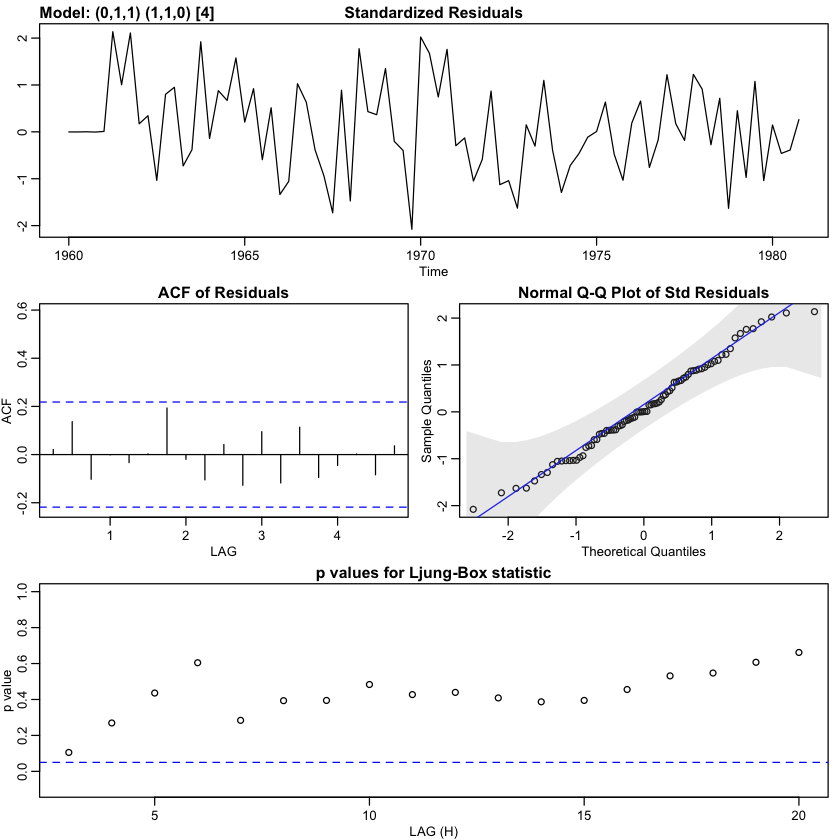

In [20]:
sarima(log(jj), 0, 1, 1, 1, 1, 0, 4)

### Time to Summarize

$$ Model - SARIMA (0, 1, 1, 1, 1, 0)_4 $$  
$$ X_t = Earnings $$  
$$ Y_t = \log(X_t) $$  
$$ (1-B)(1-B^4)(1-\Phi B^4)Y_t = (1+\theta B) Z_t $$  
$$ Y_t = Y_{t-1} + (\Phi+1)Y_{t-4} - (\Phi + 1)Y_{t-5} - \Phi Y_{t-8}+ \Phi Y_{t-9} + Z_t + \theta Z_{t-1}$$  
$$ ma1(\Phi) = -0.6796 \ \  sar1(\theta) = -0.3220 $$  
$$ Y_t = Y_{t-1} + 0.6780Y_{t-4} -0.6780Y_{t-5} + 0.3220Y_{t-8} - 0.3220Y_{t-9} + Z_t - 0.6796Z_{t-1} $$  
$$ Z_t \sim Normal(0, 0.0079) $$  

### Forecast  

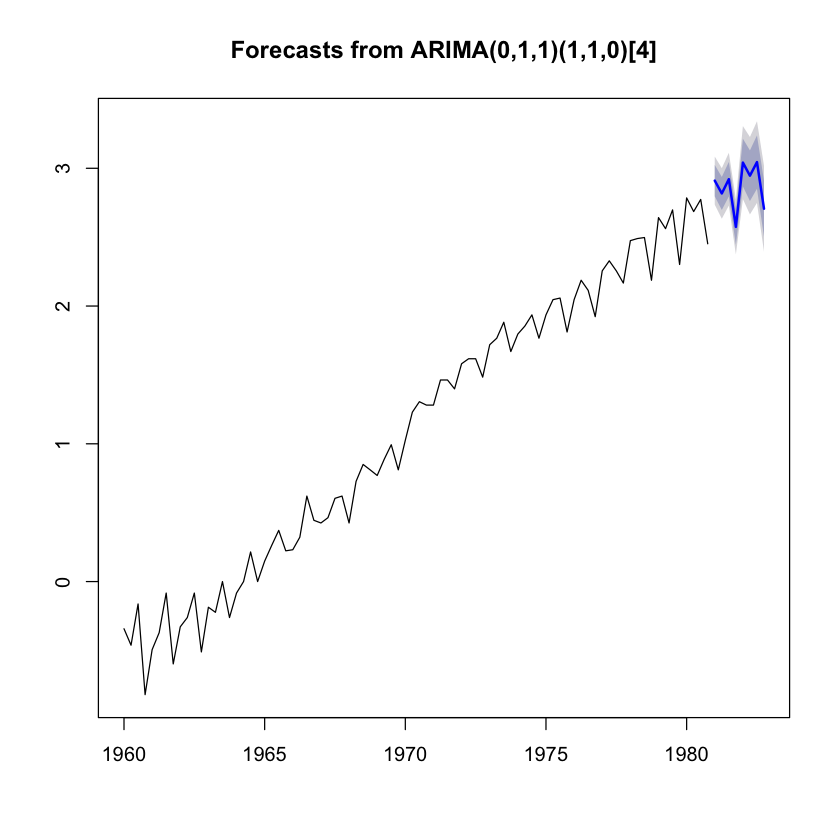

In [25]:
library(forecast)
plot(forecast(model))

In [26]:
forecast(model)

        Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
1981 Q1       2.910254 2.796250 3.024258 2.735900 3.084608
1981 Q2       2.817218 2.697507 2.936929 2.634135 3.000300
1981 Q3       2.920738 2.795579 3.045896 2.729325 3.112151
1981 Q4       2.574797 2.444419 2.705175 2.375401 2.774194
1982 Q1       3.041247 2.868176 3.214317 2.776558 3.305935
1982 Q2       2.946224 2.762623 3.129824 2.665431 3.227016
1982 Q3       3.044757 2.851198 3.238316 2.748734 3.340780
1982 Q4       2.706534 2.503505 2.909564 2.396028 3.017041